
# Weekly Contextual Bandit for Target Tech Stocks



**Refined Objective**

- Build a reproducible contextual multi-armed bandit that decides a weekly position among `AVGO`, `AAPL`, `TSLA`, `GOOGL`, and `NVDA`.
- Engineer lagged price/volume features from the local S&P 500 datasets and standardise them using the pre-2024-09-23 history.
- Simulate one year of sequential decisions (2024-09-23 → 2025-09-22), track cumulative performance, and benchmark against equal-weight and best-in-hindsight baselines.


In [1]:

import math
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Iterable, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)

import yfinance as yf


In [2]:

DATA_DIR = Path('.')
TICKERS = ["AVGO", "AAPL", "TSLA", "GOOGL", "NVDA"]
TRAIN_PATH = DATA_DIR / 'sp500_first_four_years.csv'
TEST_PATH = DATA_DIR / 'sp500_last_year.csv'
TEST_PERIOD_START = pd.Timestamp('2024-09-23')  # first trading day covered by sp500_last_year.csv
ALPHA = 0.55  # LinUCB exploration strength
np.random.seed(42)
RANDOM_SEED = 2025
SPY_TICKER = 'SPY'


In [3]:

raw_df = (
    pd.concat([
        pd.read_csv(TRAIN_PATH),
        pd.read_csv(TEST_PATH)
    ], ignore_index=True)
    .query('Ticker in @TICKERS')
    .assign(Date=lambda df_: pd.to_datetime(df_['Date']))
    .sort_values(['Ticker', 'Date'])
    .reset_index(drop=True)
)

print(f"Loaded {len(raw_df):,} rows spanning {raw_df['Date'].min().date()} to {raw_df['Date'].max().date()}.")
raw_df.head()


Loaded 6,275 rows spanning 2020-09-23 to 2025-09-22.


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,2020-09-23,AAPL,111.620003,112.110001,106.769997,107.120003,104.197533,150718700.0
1,2020-09-24,AAPL,105.169998,110.250000,105.000000,108.220001,105.267517,167743300.0
2,2020-09-25,AAPL,108.430000,112.440002,107.669998,112.279999,109.216751,149981400.0
3,2020-09-28,AAPL,115.010002,115.320000,112.779999,114.959999,111.823647,137672400.0
4,2020-09-29,AAPL,114.550003,115.309998,113.570000,114.089996,110.977379,99382200.0


In [4]:

spy_daily = (
    yf.download(
        SPY_TICKER,
        start=(raw_df['Date'].min() - pd.Timedelta(days=7)).strftime('%Y-%m-%d'),
        end=(raw_df['Date'].max() + pd.Timedelta(days=7)).strftime('%Y-%m-%d'),
        progress=False,
        auto_adjust=False,
    )
    .rename_axis(index='Date', columns=['Price', 'Ticker'])
)

if isinstance(spy_daily.columns, pd.MultiIndex):
    spy_daily = spy_daily.xs(SPY_TICKER, axis=1, level='Ticker')

spy_daily = spy_daily.reset_index()

if spy_daily.empty:
    raise RuntimeError('Failed to download SPY data from Yahoo Finance.')

spy_daily['Date'] = pd.to_datetime(spy_daily['Date'])
spy_daily = spy_daily[['Date', 'Open', 'Adj Close', 'Close']]
spy_daily.head()


Price,Date,Open,Adj Close,Close
0,2020-09-16,341.510010,314.609222,338.820007
1,2020-09-17,333.559998,311.842194,335.839996
2,2020-09-18,335.369995,308.252014,330.649994
3,2020-09-21,325.700012,304.821289,326.970001
4,2020-09-22,328.570007,307.925781,330.299988



### Feature Engineering
Lagged technical features give each arm (stock) a context vector built only from information available prior to the investment week.


In [5]:

def compute_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    delta = prices.diff()
    gains = delta.clip(lower=0)
    losses = -delta.clip(upper=0)
    avg_gain = gains.rolling(window).mean()
    avg_loss = losses.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def engineer_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Tuple[str, ...]]:
    df = df.sort_values(['Ticker', 'Date']).copy()

    grp = df.groupby('Ticker')
    df['daily_return'] = grp['Adj Close'].pct_change()

    df['avg_return_5'] = grp['daily_return'].rolling(5).mean().reset_index(level=0, drop=True)
    df['avg_return_21'] = grp['daily_return'].rolling(21).mean().reset_index(level=0, drop=True)
    df['volatility_5'] = grp['daily_return'].rolling(5).std().reset_index(level=0, drop=True)
    df['volatility_21'] = grp['daily_return'].rolling(21).std().reset_index(level=0, drop=True)

    sma_5 = grp['Adj Close'].rolling(5).mean().reset_index(level=0, drop=True)
    sma_21 = grp['Adj Close'].rolling(21).mean().reset_index(level=0, drop=True)
    df['price_vs_sma_5'] = df['Adj Close'] / sma_5
    df['price_vs_sma_21'] = df['Adj Close'] / sma_21

    volume_mean_20 = grp['Volume'].rolling(20).mean().reset_index(level=0, drop=True)
    df['volume_rel_20'] = df['Volume'] / volume_mean_20

    df['rsi_14'] = grp['Adj Close'].transform(lambda s: compute_rsi(s, 14))

    feature_cols = (
        'avg_return_5',
        'avg_return_21',
        'volatility_5',
        'volatility_21',
        'price_vs_sma_5',
        'price_vs_sma_21',
        'volume_rel_20',
        'rsi_14',
    )

    df[list(feature_cols)] = grp[list(feature_cols)].shift(1)
    df = df.dropna(subset=feature_cols)
    return df, feature_cols

feature_df, FEATURE_COLS = engineer_features(raw_df)
print(f"Feature frame rows: {len(feature_df):,}")
feature_df.head()


Feature frame rows: 6,165


,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,daily_return,avg_return_5,avg_return_21,volatility_5,volatility_21,price_vs_sma_5,price_vs_sma_21,volume_rel_20,rsi_14
22,2020-10-23,AAPL,116.389999,116.550003,114.279999,115.040001,111.901451,82572600.0,-0.006134,-0.008276,0.003965,0.014155,0.023886,0.989096,0.994424,0.767595,54.524316
23,2020-10-26,AAPL,114.010002,116.550003,112.879997,115.050003,111.911179,111850700.0,0.000087,-0.006703,0.003184,0.013792,0.023938,0.989762,0.985574,0.637644,47.335781
24,2020-10-27,AAPL,115.489998,117.279999,114.540001,116.599998,113.418884,92276800.0,0.013472,-0.001577,0.001402,0.008955,0.022610,0.991434,0.984547,0.872434,53.926056
25,2020-10-28,AAPL,115.050003,115.430000,111.099998,111.199997,108.166199,143937800.0,-0.046312,-0.001521,0.000907,0.009070,0.022204,1.006370,0.997145,0.721758,53.206708
26,2020-10-29,AAPL,112.370003,116.930000,112.199997,115.320000,112.173828,146129200.0,0.037051,-0.009694,-0.000938,0.022282,0.024440,0.969249,0.952086,1.125277,43.497773



### Weekly contexts and rewards
We aggregate the daily features to the first trading day of each week and measure reward as the weekly return from the entry open to the final close within that week.


In [6]:

def build_weekly_frame(df: pd.DataFrame, feature_cols: Iterable[str]) -> pd.DataFrame:
    df = df.copy()
    df['week_start'] = df['Date'].dt.to_period('W-MON').dt.to_timestamp()
    df = df.sort_values(['Ticker', 'week_start', 'Date'])

    week_start = df.groupby(['Ticker', 'week_start']).first().reset_index()
    week_end = df.groupby(['Ticker', 'week_start']).last().reset_index()[['Ticker', 'week_start', 'Date', 'Adj Close']]
    week_end = week_end.rename(columns={'Date': 'week_end', 'Adj Close': 'Adj Close_week_end'})

    weekly = (
        week_start
        .merge(week_end, on=['Ticker', 'week_start'], how='inner')
        .dropna(subset=list(feature_cols))
        .sort_values(['week_start', 'Ticker'])
        .reset_index(drop=True)
    )

    weekly['weekly_return'] = weekly['Adj Close_week_end'] / weekly['Open'] - 1.0
    weekly = weekly.dropna(subset=['weekly_return'])
    return weekly

weekly_df = build_weekly_frame(feature_df, FEATURE_COLS)
print(f"Weekly rows (pre-filter): {len(weekly_df):,}")
weekly_df.head()


Weekly rows (pre-filter): 1,285


,Ticker,week_start,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,avg_return_5,avg_return_21,volatility_5,volatility_21,price_vs_sma_5,price_vs_sma_21,volume_rel_20,rsi_14,week_end,Adj Close_week_end,weekly_return
0,AAPL,2020-10-20,2020-10-23,116.389999,116.550003,114.279999,115.040001,111.901451,82572600.0,-0.006134,-0.008276,0.003965,0.014155,0.023886,0.989096,0.994424,0.767595,54.524316,2020-10-26,111.911179,-0.038481
1,AVGO,2020-10-20,2020-10-23,37.326000,37.394001,37.076000,37.271999,33.367569,8868000.0,-0.001741,-0.003457,0.002955,0.007146,0.013685,0.994682,1.008010,0.837986,68.803814,2020-10-26,32.500969,-0.129267
2,GOOGL,2020-10-20,2020-10-23,80.752502,81.706001,80.595497,81.649002,81.089729,30548000.0,0.016382,0.006627,0.006366,0.017953,0.015102,1.024475,1.065205,0.876736,74.101622,2020-10-26,78.671898,-0.025765
3,NVDA,2020-10-20,2020-10-23,13.450000,13.593250,13.291250,13.590250,13.548889,233484000.0,0.017158,-0.008815,0.004850,0.012258,0.021180,0.984736,0.984446,0.678652,55.390175,2020-10-26,13.101256,-0.025929
4,TSLA,2020-10-20,2020-10-23,140.613327,140.963333,135.793335,140.210007,140.210007,101151000.0,-0.012119,-0.010429,0.005808,0.013834,0.029569,0.994432,0.994334,0.915492,54.742069,2020-10-26,140.093338,-0.003698


In [7]:

coverage = weekly_df.groupby('week_start')['Ticker'].nunique()
complete_weeks = coverage[coverage == len(TICKERS)].index
weekly_df = weekly_df[weekly_df['week_start'].isin(complete_weeks)].reset_index(drop=True)
print(f"Weeks with full coverage: {weekly_df['week_start'].nunique()}")


Weeks with full coverage: 257


In [8]:

spy_weekly = (
    spy_daily.assign(week_start=lambda df_: df_['Date'].dt.to_period('W-MON').dt.to_timestamp())
    .sort_values(['week_start', 'Date'])
    .groupby('week_start')
    .agg(
        week_open=('Open', 'first'),
        week_close=('Adj Close', 'last')
    )
    .reset_index()
)

spy_weekly['weekly_return'] = spy_weekly['week_close'] / spy_weekly['week_open'] - 1.0
spy_weekly = spy_weekly[spy_weekly['week_start'].isin(weekly_df['week_start'])].reset_index(drop=True)

if spy_weekly.empty:
    raise RuntimeError('SPY weekly frame is empty — check download window alignment.')

spy_weekly_map = spy_weekly.set_index('week_start')['weekly_return'].to_dict()
spy_weekly.head()


,week_start,week_open,week_close,weekly_return
0,2020-10-20,343.459991,316.400055,-0.078786
1,2020-10-27,339.760010,307.832489,-0.093971
2,2020-11-03,333.690002,330.542358,-0.009433
3,2020-11-10,353.489990,338.009735,-0.043793
4,2020-11-17,359.970001,333.245972,-0.074240


In [9]:

train_mask = weekly_df['week_start'] < TEST_PERIOD_START
feature_means = weekly_df.loc[train_mask, FEATURE_COLS].mean()
feature_stds = weekly_df.loc[train_mask, FEATURE_COLS].std().replace(0, 1.0)
weekly_df.loc[:, FEATURE_COLS] = (weekly_df.loc[:, FEATURE_COLS] - feature_means) / feature_stds

feature_stats = pd.DataFrame({'mean': feature_means, 'std': feature_stds})
feature_stats


,mean,std
avg_return_5,0.001508,0.012304
avg_return_21,0.001624,0.006049
volatility_5,0.023039,0.014069
volatility_21,0.024751,0.011037
price_vs_sma_5,1.003046,0.030343
price_vs_sma_21,1.013155,0.071294
volume_rel_20,0.989486,0.337631
rsi_14,54.151194,16.912512



### LinUCB implementation


In [10]:

@dataclass
class LinUCB:
    arms: Tuple[str, ...]
    n_features: int
    alpha: float

    def __post_init__(self):
        self.A = {arm: np.eye(self.n_features) for arm in self.arms}
        self.b = {arm: np.zeros(self.n_features) for arm in self.arms}

    def select(self, contexts: Dict[str, np.ndarray]) -> Tuple[str, Dict[str, float], Dict[str, Dict[str, float]]]:
        scores: Dict[str, float] = {}
        diagnostics: Dict[str, Dict[str, float]] = {}
        for arm, x in contexts.items():
            x = np.asarray(x, dtype=float)
            A_inv = np.linalg.inv(self.A[arm])
            theta = A_inv @ self.b[arm]
            mean = float(theta @ x)
            bonus = self.alpha * math.sqrt(max(x @ A_inv @ x, 1e-12))
            ucb = mean + bonus
            scores[arm] = ucb
            diagnostics[arm] = {'mean': mean, 'bonus': bonus, 'ucb': ucb}
        best_arm = max(scores, key=scores.get)
        return best_arm, scores, diagnostics

    def update(self, arm: str, x: np.ndarray, reward: float) -> None:
        x = np.asarray(x, dtype=float)
        self.A[arm] += np.outer(x, x)
        self.b[arm] += reward * x



### Simulate sequential weekly decisions
The agent observes contexts, chooses an arm, receives the realised weekly return, and updates the value estimates. Only the 2024-09-23 → 2025-09-22 period is counted towards reported performance.


In [11]:

rng = np.random.default_rng(RANDOM_SEED)
bandit = LinUCB(arms=tuple(TICKERS), n_features=len(FEATURE_COLS) + 1, alpha=ALPHA)
portfolio = 1.0
equal_weight_portfolio = 1.0
random_portfolio = 1.0
spy_portfolio = 1.0
optimal_portfolio = 1.0
train_records = []
test_records = []

for week_start, week_slice in weekly_df.groupby('week_start'):
    contexts = {}
    for row in week_slice.itertuples(index=False):
        feature_vector = np.array([getattr(row, col) for col in FEATURE_COLS], dtype=float)
        if np.any(np.isnan(feature_vector)):
            continue
        contexts[row.Ticker] = np.concatenate(([1.0], feature_vector))

    if len(contexts) < len(TICKERS):
        continue

    chosen_arm, scores, diagnostics = bandit.select(contexts)
    reward = week_slice.loc[week_slice['Ticker'] == chosen_arm, 'weekly_return'].iloc[0]
    equal_weight_return = week_slice['weekly_return'].mean()
    best_idx = week_slice['weekly_return'].idxmax()
    best_row = week_slice.loc[best_idx]
    best_return = best_row['weekly_return']

    random_arm = rng.choice(TICKERS)
    random_reward = week_slice.loc[week_slice['Ticker'] == random_arm, 'weekly_return'].iloc[0]
    try:
        spy_return = spy_weekly_map[week_start]
    except KeyError as exc:
        raise KeyError(f"Missing SPY return for week {week_start:%Y-%m-%d}") from exc

    bandit.update(chosen_arm, contexts[chosen_arm], reward)

    sorted_scores = sorted(scores.values(), reverse=True)
    score_gap = sorted_scores[0] - sorted_scores[1] if len(sorted_scores) > 1 else np.nan

    record = {
        'week_start': week_start,
        'chosen_ticker': chosen_arm,
        'reward': reward,
        'equal_weight_return': equal_weight_return,
        'random_ticker': random_arm,
        'random_return': random_reward,
        'spy_return': spy_return,
        'best_ticker': best_row['Ticker'],
        'best_return': best_return,
        'scores': scores,
        'diagnostics': diagnostics,
        'chosen_mean': diagnostics[chosen_arm]['mean'],
        'chosen_bonus': diagnostics[chosen_arm]['bonus'],
        'chosen_ucb': diagnostics[chosen_arm]['ucb'],
        'score_gap': score_gap,
    }

    if week_start >= TEST_PERIOD_START:
        portfolio *= (1 + reward)
        equal_weight_portfolio *= (1 + equal_weight_return)
        random_portfolio *= (1 + random_reward)
        spy_portfolio *= (1 + spy_return)
        optimal_portfolio *= (1 + best_return)
        record.update({
            'portfolio': portfolio,
            'equal_weight_portfolio': equal_weight_portfolio,
            'random_portfolio': random_portfolio,
            'spy_portfolio': spy_portfolio,
            'optimal_portfolio': optimal_portfolio,
            'bandit_over_spy': portfolio / spy_portfolio,
            'random_over_spy': random_portfolio / spy_portfolio,
            'phase': 'test',
        })
        test_records.append(record)
    else:
        record['phase'] = 'train'
        train_records.append(record)

results_df = pd.DataFrame(test_records)
print(f"Evaluated {len(results_df)} test weeks.")
results_df.head()


Evaluated 52 test weeks.


,week_start,chosen_ticker,reward,equal_weight_return,random_ticker,random_return,spy_return,best_ticker,best_return,scores,diagnostics,chosen_mean,chosen_bonus,chosen_ucb,score_gap,portfolio,equal_weight_portfolio,random_portfolio,spy_portfolio,optimal_portfolio,bandit_over_spy,random_over_spy,phase
0,2024-09-24,AVGO,-0.009795,0.017796,NVDA,0.041926,-0.006331,NVDA,0.041926,"{'AAPL': 0.17081187690447713, 'AVGO': 0.189264...","{'AAPL': {'mean': -0.03826005039904196, 'bonus...",-0.043890,0.233155,0.189264,0.008789,0.990205,1.017796,1.041926,0.993669,1.041926,0.996514,1.048564,test
1,2024-10-01,GOOGL,-0.032355,-0.019344,GOOGL,-0.032355,-0.021661,NVDA,0.048562,"{'AAPL': 0.15893992011479696, 'AVGO': 0.195199...","{'AAPL': {'mean': -0.037008120912427764, 'bonu...",-0.010296,0.272588,0.262292,0.067093,0.958167,0.998108,1.008214,0.972146,1.092524,0.985621,1.037102,test
2,2024-10-08,AVGO,0.030946,0.003731,NVDA,0.059653,0.012064,NVDA,0.059653,"{'AAPL': 0.18033294326512844, 'AVGO': 0.290931...","{'AAPL': {'mean': -0.01091846273382274, 'bonus...",0.008767,0.282164,0.290932,0.090928,0.987819,1.001832,1.068358,0.983873,1.157696,1.004010,1.085869,test
3,2024-10-15,GOOGL,-0.014720,0.003452,TSLA,-0.005272,-0.013634,NVDA,0.042060,"{'AAPL': 0.13169309656892103, 'AVGO': 0.131914...","{'AAPL': {'mean': -0.038734529265656285, 'bonu...",-0.008527,0.198434,0.189906,0.003213,0.973278,1.005290,1.062725,0.970459,1.206389,1.002905,1.095074,test
4,2024-10-22,NVDA,-0.017006,0.031569,TSLA,0.207998,-0.012385,TSLA,0.207998,"{'AAPL': 0.1220461149581412, 'AVGO': 0.1324783...","{'AAPL': {'mean': -0.027959999122632268, 'bonu...",0.006171,0.215297,0.221468,0.007085,0.956727,1.037026,1.283769,0.958440,1.457316,0.998213,1.339437,test



### Performance summary


In [12]:

if results_df.empty:
    raise RuntimeError("No test weeks were evaluated — check date filters.")

def max_drawdown(series: pd.Series) -> float:
    running_max = series.cummax()
    drawdowns = series / running_max - 1.0
    return float(drawdowns.min())

strategies = {
    'bandit': {
        'returns': results_df['reward'],
        'portfolio': results_df['portfolio'],
    },
    'equal_weight': {
        'returns': results_df['equal_weight_return'],
        'portfolio': results_df['equal_weight_portfolio'],
    },
    'random': {
        'returns': results_df['random_return'],
        'portfolio': results_df['random_portfolio'],
    },
    'spy': {
        'returns': results_df['spy_return'],
        'portfolio': results_df['spy_portfolio'],
    },
}

weeks = len(results_df)
spy_final = strategies['spy']['portfolio'].iloc[-1]

metrics = {
    'metric': [
        'weeks',
        'final_value',
        'total_return',
        'final_vs_spy',
        'avg_weekly_return',
        'annualised_return',
        'annualised_vol',
        'sharpe_ratio',
        'win_rate',
        'max_drawdown',
    ]
}

def summarise(returns, portfolio):
    final_value = portfolio.iloc[-1]
    total_return = final_value - 1
    avg_weekly_return = returns.mean()
    weekly_vol = returns.std(ddof=1)
    annualised_return = (1 + avg_weekly_return) ** 52 - 1
    annualised_vol = weekly_vol * math.sqrt(52) if weekly_vol > 0 else float('nan')
    sharpe = (
        annualised_return / annualised_vol
        if annualised_vol and not math.isnan(annualised_vol)
        else float('nan')
    )
    win_rate = (returns > 0).mean()
    return {
        'weeks': weeks,
        'final_value': final_value,
        'total_return': total_return,
        'final_vs_spy': final_value / spy_final,
        'avg_weekly_return': avg_weekly_return,
        'annualised_return': annualised_return,
        'annualised_vol': annualised_vol,
        'sharpe_ratio': sharpe,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown(portfolio),
    }

for name, payload in strategies.items():
    stats = summarise(payload['returns'], payload['portfolio'])
    metrics[name] = [stats[key] for key in metrics['metric']]

summary = pd.DataFrame(metrics)
summary


,metric,bandit,equal_weight,random,spy
0,weeks,52.000000,52.000000,52.000000,52.000000
1,final_value,1.909078,1.374223,0.923239,0.774702
2,total_return,0.909078,0.374223,-0.076761,-0.225298
3,final_vs_spy,2.464275,1.773874,1.191735,1.000000
4,avg_weekly_return,0.015476,0.007409,0.000892,-0.004585
5,annualised_return,1.222347,0.467885,0.047462,-0.212573
6,annualised_vol,0.593281,0.369244,0.515744,0.179867
7,sharpe_ratio,2.060319,1.267144,0.092027,-1.181833
8,win_rate,0.557692,0.596154,0.461538,0.500000
9,max_drawdown,-0.267162,-0.373147,-0.539034,-0.341157



### Baselines vs individual tickers


In [13]:

ticker_weeks = results_df['week_start'].tolist()
ticker_returns = (
    weekly_df[weekly_df['week_start'].isin(ticker_weeks)]
    .pivot(index='week_start', columns='Ticker', values='weekly_return')
    .reindex(ticker_weeks)
)

if ticker_returns.isnull().values.any():
    missing_counts = ticker_returns.isnull().sum()
    raise ValueError(f"Missing ticker returns for weeks: {missing_counts[missing_counts > 0].to_dict()}")

ticker_portfolios = (1 + ticker_returns).cumprod()
bandit_final = results_df['portfolio'].iloc[-1]
spy_final = results_df['spy_portfolio'].iloc[-1]

def max_drawdown(series: pd.Series) -> float:
    running_max = series.cummax()
    drawdowns = series / running_max - 1.0
    return float(drawdowns.min())

ticker_rows = []
for ticker, series in ticker_returns.items():
    cumulative = ticker_portfolios[ticker]
    final_value = cumulative.iloc[-1]
    avg_weekly_return = series.mean()
    weekly_vol = series.std(ddof=1)
    annualised_return = (1 + avg_weekly_return) ** 52 - 1
    annualised_vol = weekly_vol * math.sqrt(52) if weekly_vol > 0 else float('nan')
    sharpe = (
        annualised_return / annualised_vol
        if annualised_vol and not math.isnan(annualised_vol)
        else float('nan')
    )
    win_rate = (series > 0).mean()
    ticker_rows.append({
        'ticker': ticker,
        'final_value': final_value,
        'total_return': final_value - 1,
        'bandit_over_ticker': bandit_final / final_value,
        'ticker_over_spy': final_value / spy_final,
        'avg_weekly_return': avg_weekly_return,
        'annualised_return': annualised_return,
        'annualised_vol': annualised_vol,
        'sharpe_ratio': sharpe,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown(cumulative),
    })

ticker_summary = pd.DataFrame(ticker_rows).sort_values('final_value', ascending=False).reset_index(drop=True)
ticker_summary


,ticker,final_value,total_return,bandit_over_ticker,ticker_over_spy,avg_weekly_return,annualised_return,annualised_vol,sharpe_ratio,win_rate,max_drawdown
0,TSLA,1.532527,0.532527,1.245706,1.978216,0.013727,1.031813,0.793586,1.300190,0.461538,-0.533010
1,AVGO,1.414175,0.414175,1.349959,1.825445,0.009901,0.669122,0.609072,1.098592,0.538462,-0.462449
2,NVDA,1.268005,0.268005,1.505575,1.636766,0.006735,0.417696,0.474186,0.880868,0.596154,-0.419563
3,GOOGL,1.254300,0.254300,1.522026,1.619075,0.005263,0.313846,0.308723,1.016592,0.615385,-0.315184
4,AAPL,1.020193,0.020193,1.871290,1.316886,0.001418,0.076448,0.326663,0.234029,0.557692,-0.281950



### Cumulative value comparison


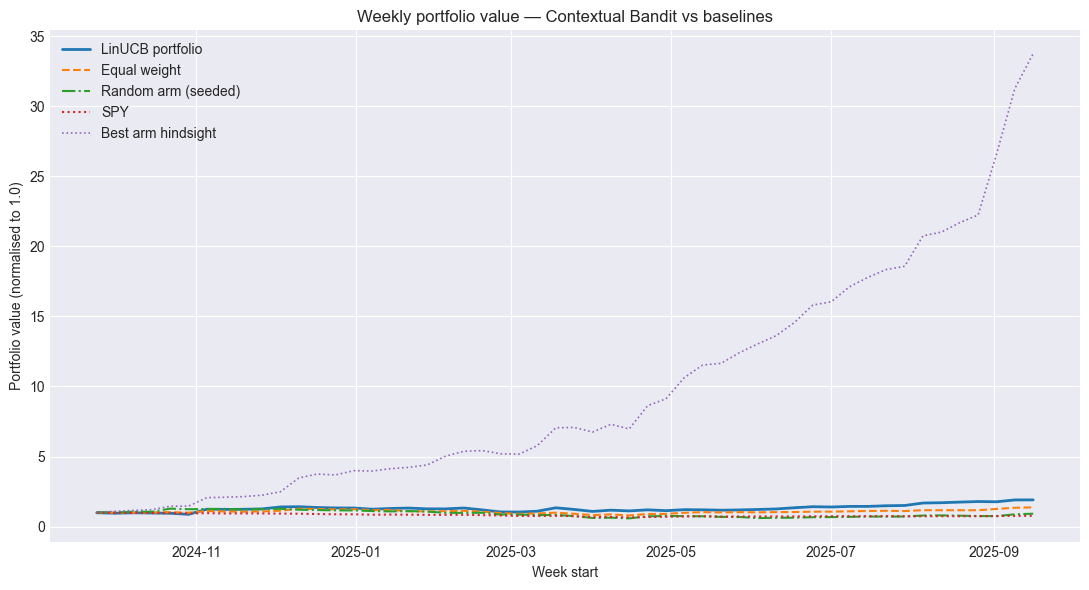

In [14]:

plt.figure(figsize=(11, 6))
plt.plot(results_df['week_start'], results_df['portfolio'], label='LinUCB portfolio', linewidth=2)
plt.plot(results_df['week_start'], results_df['equal_weight_portfolio'], label='Equal weight', linestyle='--')
plt.plot(results_df['week_start'], results_df['random_portfolio'], label='Random arm (seeded)', linestyle='-.')
plt.plot(results_df['week_start'], results_df['spy_portfolio'], label='SPY', linestyle=':')
plt.plot(results_df['week_start'], results_df['optimal_portfolio'], label='Best arm hindsight', linestyle=':', linewidth=1.2)
plt.ylabel('Portfolio value (normalised to 1.0)')
plt.xlabel('Week start')
plt.legend()
plt.title('Weekly portfolio value — Contextual Bandit vs baselines')
plt.tight_layout()
plt.show()



### Recent decisions snapshot


In [15]:

latest = (
    results_df[
        [
            'week_start',
            'chosen_ticker',
            'reward',
            'random_ticker',
            'random_return',
            'equal_weight_return',
            'spy_return',
            'best_ticker',
            'best_return',
        ]
    ]
    .tail(8)
    .reset_index(drop=True)
)
latest


,week_start,chosen_ticker,reward,random_ticker,random_return,equal_weight_return,spy_return,best_ticker,best_return
0,2025-07-29,GOOGL,0.012658,NVDA,0.011406,-0.015375,-0.013981,GOOGL,0.012658
1,2025-08-05,AAPL,0.116912,TSLA,0.097362,0.055927,0.003754,AAPL,0.116912
2,2025-08-12,AAPL,0.012631,AAPL,0.012631,-0.002860,0.005063,AAPL,0.012631
3,2025-08-19,GOOGL,0.025975,AVGO,-0.027082,-0.000229,-0.003773,TSLA,0.032193
4,2025-08-26,AAPL,0.023229,TSLA,-0.032064,-0.001222,0.001661,GOOGL,0.025106
5,2025-09-02,NVDA,-0.009997,NVDA,-0.009997,0.080087,0.014959,AVGO,0.194615
6,2025-09-09,GOOGL,0.074476,TSLA,0.176788,0.068562,0.015583,TSLA,0.176788
7,2025-09-16,GOOGL,0.001785,TSLA,0.047551,0.018693,0.008118,AAPL,0.079686


### Weekly returns vs baselines

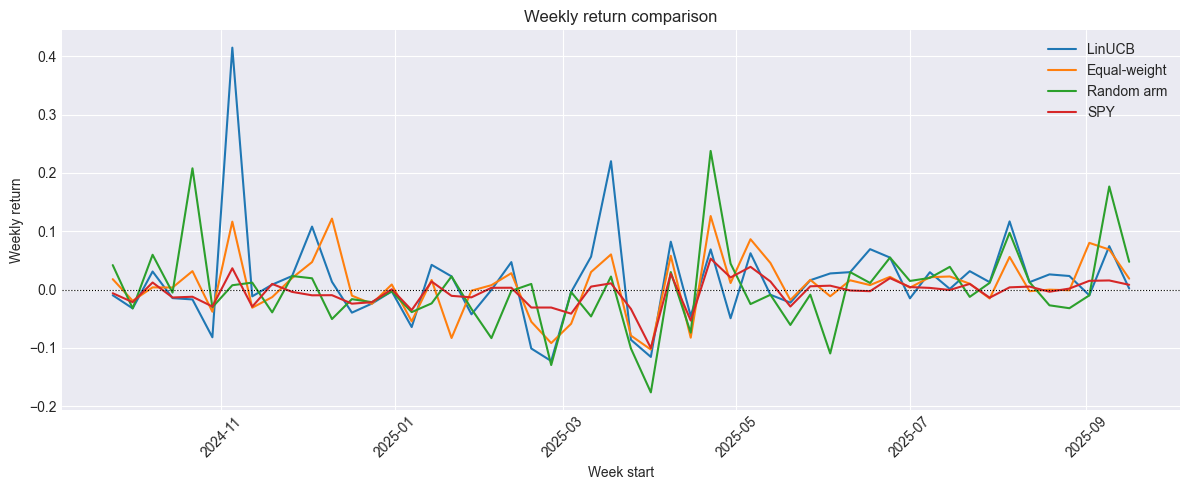

In [16]:

weekly_returns = (
    results_df[
        ['week_start', 'reward', 'equal_weight_return', 'random_return', 'spy_return']
    ]
    .rename(
        columns={
            'reward': 'LinUCB',
            'equal_weight_return': 'Equal-weight',
            'random_return': 'Random arm',
            'spy_return': 'SPY',
        }
    )
    .set_index('week_start')
)

fig, ax = plt.subplots(figsize=(12, 5))
for label, series in weekly_returns.items():
    ax.plot(series.index, series.values, label=label)
ax.axhline(0, color='black', linewidth=0.8, linestyle=':')
ax.set_ylabel('Weekly return')
ax.set_xlabel('Week start')
ax.set_title('Weekly return comparison')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Action distribution and excess edge

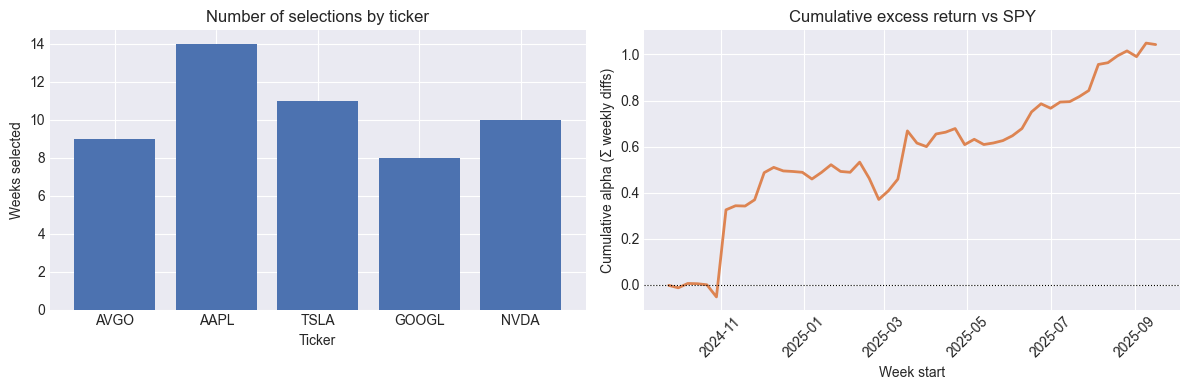

In [17]:

selection_counts = results_df['chosen_ticker'].value_counts().reindex(TICKERS, fill_value=0)
cumulative_alpha = (results_df['reward'] - results_df['spy_return']).cumsum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(selection_counts.index, selection_counts.values, color='#4c72b0')
axes[0].set_title('Number of selections by ticker')
axes[0].set_ylabel('Weeks selected')
axes[0].set_xlabel('Ticker')

axes[1].plot(results_df['week_start'], cumulative_alpha, color='#dd8452', linewidth=2)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle=':')
axes[1].set_title('Cumulative excess return vs SPY')
axes[1].set_ylabel('Cumulative alpha (Σ weekly diffs)')
axes[1].set_xlabel('Week start')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### UCB diagnostic traces

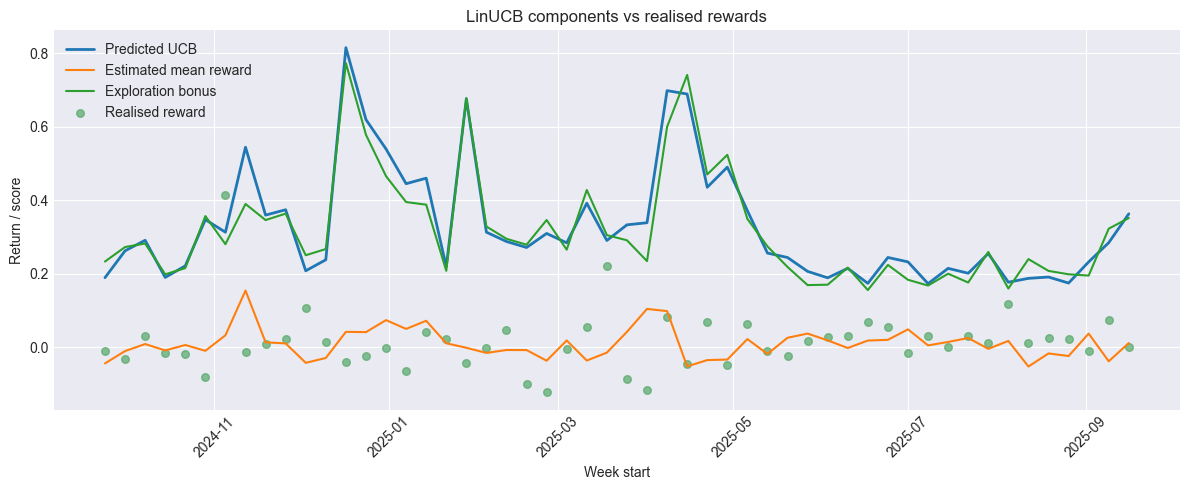

In [18]:

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(results_df['week_start'], results_df['chosen_ucb'], label='Predicted UCB', linewidth=2)
ax.plot(results_df['week_start'], results_df['chosen_mean'], label='Estimated mean reward', linewidth=1.5)
ax.plot(results_df['week_start'], results_df['chosen_bonus'], label='Exploration bonus', linewidth=1.5)
ax.scatter(results_df['week_start'], results_df['reward'], label='Realised reward', color='#55a868', s=30, alpha=0.7)
ax.set_title('LinUCB components vs realised rewards')
ax.set_ylabel('Return / score')
ax.set_xlabel('Week start')
ax.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Bandit architecture overview

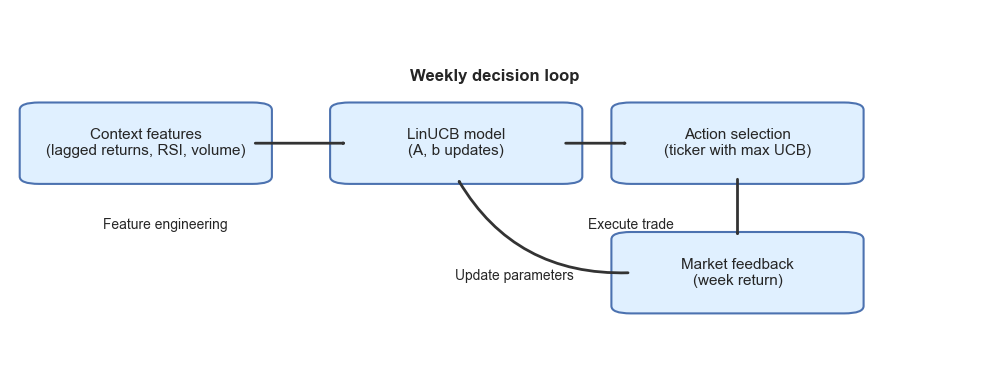

In [19]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

def add_box(ax, xy, text, width=0.22, height=0.18):
    box = FancyBboxPatch(
        xy,
        width,
        height,
        boxstyle='round,pad=0.02',
        linewidth=1.5,
        edgecolor='#4c72b0',
        facecolor='#e0f0ff'
    )
    ax.add_patch(box)
    ax.text(
        xy[0] + width / 2,
        xy[1] + height / 2,
        text,
        ha='center',
        va='center',
        fontsize=11,
    )
    return box

context_box = add_box(ax, (0.03, 0.55), 'Context features\n(lagged returns, RSI, volume)')
linucb_box = add_box(ax, (0.35, 0.55), 'LinUCB model\n(A, b updates)')
policy_box = add_box(ax, (0.64, 0.55), 'Action selection\n(ticker with max UCB)')
reward_box = add_box(ax, (0.64, 0.2), 'Market feedback\n(week return)')

arrows = [
    FancyArrowPatch(
        (context_box.get_x() + context_box.get_width(), context_box.get_y() + context_box.get_height() / 2),
        (linucb_box.get_x(), linucb_box.get_y() + linucb_box.get_height() / 2),
        arrowstyle='-|>',
        linewidth=2,
        color='#333333'
    ),
    FancyArrowPatch(
        (linucb_box.get_x() + linucb_box.get_width(), linucb_box.get_y() + linucb_box.get_height() / 2),
        (policy_box.get_x(), policy_box.get_y() + policy_box.get_height() / 2),
        arrowstyle='-|>',
        linewidth=2,
        color='#333333'
    ),
    FancyArrowPatch(
        (policy_box.get_x() + policy_box.get_width() / 2, policy_box.get_y()),
        (reward_box.get_x() + reward_box.get_width() / 2, reward_box.get_y() + reward_box.get_height()),
        arrowstyle='-|>',
        linewidth=2,
        color='#333333'
    ),
    FancyArrowPatch(
        (reward_box.get_x(), reward_box.get_y() + reward_box.get_height() / 2),
        (linucb_box.get_x() + linucb_box.get_width() / 2, linucb_box.get_y()),
        connectionstyle='arc3,rad=-0.3',
        arrowstyle='-|>',
        linewidth=2,
        color='#333333'
    ),
]

for arrow in arrows:
    ax.add_patch(arrow)

ax.text(0.5, 0.82, 'Weekly decision loop', ha='center', va='center', fontsize=12, fontweight='bold')
ax.text(0.52, 0.28, 'Update parameters', ha='center', va='center', fontsize=10)
ax.text(0.64, 0.42, 'Execute trade', ha='center', va='center', fontsize=10)
ax.text(0.16, 0.42, 'Feature engineering', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()
